In [1]:
import contractions
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import neattext as nt
import nltk
from nltk.corpus import words, names
from nltk.probability import FreqDist
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
#import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis
import re
import seaborn as sns
import string
#import textacy
#from textacy import preprocessing
#from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [2]:
filename=r'..\DatasetEnglish.csv'
data=pd.read_csv(filename)

In [3]:
data=data.drop(['index'], axis=1)
data.head()

,mongodb_id,has_preview,shortened_url,comments_enabled,comments_logged_in_only,talk_id,talk_slug,talk_title,talk_social_title,speakers_name,...,related_talk_5_id,speakers_typename,speakers_firstname,speakers_lastname,speakers_description,speakers_is_live,speakers_who_they_are,speakers_why_listen,external_service,external_service_code
0,652af294d95841780141bab7,False,https://go.ted.com/6Ryx,False,False,2147,aakash_odedra_a_dance_in_a_hurricane_of_paper_...,"A dance in a hurricane of paper, wind and light","A dance in a hurricane of paper, wind and light",Aakash Odedra,...,2273.0,AcmeSpeaker,Aakash,Odedra,Choreographer,True,Aakash Odedra sets raw ancient dance forms fro...,Based in the UK with a growing international r...,YouTube,T49IjKho5y8
1,652af54dd95841780141bab8,False,https://go.ted.com/6sZX,False,False,2683,aala_el_khani_what_it_s_like_to_be_a_parent_in...,What it's like to be a parent in a war zone,What it's like to be a parent in a war zone,Aala El-Khani,...,36063.0,AcmeSpeaker,Aala,El-Khani,Humanitarian psychologist,True,Aala El-Khani explores the needs of families a...,<p>Dr. Aala El-Khani researches and develops i...,YouTube,dY9f9bFctUE
2,652af54dd95841780141bab9,False,https://go.ted.com/6yKv,False,False,91525,aarathi_krishnan_5_ethical_principles_for_digi...,5 ethical principles for digitizing humanitari...,NaN,Aarathi Krishnan,...,24354.0,AcmeSpeaker,Aarathi,Krishnan,Tech and human rights ethicist,True,Aarathi Krishnan designs institutions and syst...,<p>Aarathi Krishnan works at the intersections...,YouTube,Ix8Cz-veat4
3,652af54dd95841780141baba,False,https://go.ted.com/6RgH,True,True,101504,aaron_bastani_a_socialist_perspective_on_the_p...,A socialist perspective on the pursuit of happ...,NaN,Aaron Bastani,...,972.0,AcmeSpeaker,Aaron,Bastani,Journalist,True,Aaron Bastani covers the issues that will defi...,<div>Aaron Bastani is the cofounder of Novara ...,YouTube,M6aq2SH-xVo
4,652af54dd95841780141babb,False,https://go.ted.com/6JLM,False,False,14610,aaron_duffy_lake_buckley_and_jack_foster_illus...,"""Illusions for a better society""","""Illusions for a better society""","Aaron Duffy, Lake Buckley and Jack Foster",...,NaN,AcmeSpeaker,Aaron,Duffy,NaN,False,Aaron Duffy began employing visual tricks into...,NaN,NaN,NaN


In [4]:
df=data.loc[:,['transcript','talk_id','published_timestamp']]
df.head()

,transcript,talk_id,published_timestamp
0,(Music) (Applause),2147,2014-12-05T16:00:35Z
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z


---
## Prepocessing the transcripts
- audio descriptions
- speaker change/identification
- removing special characters
- tokenizing
- removing stop words
- lemmatizing

### Creating a function to export the summary of the transcript columns

In [27]:
def column_summary(series):
    series = series.dropna()
    series = series.str.strip()
    series = series[series != ""]
    summary = {}
    functions = [len, lambda x: len(x.split()), lambda x: len(x.split(".")), lambda x: sum(nt.TextFrame(x).count_vowels().values()), 
                 lambda x: sum(nt.TextFrame(x).count_consonants().values()), lambda x: sum(nt.TextFrame(x).count_stopwords().values()), lambda x: sum(c in ".,;:!?\"'()-" for c in x)]
    labels = ["Length", "Words", "Sentences", "Vowels", "Consonants", "Stopwords", "Punctuations"]
    
    for function, label in zip(functions, labels):
        values = []
        for text in series:
            value = function(text)
            values.append(value)
            
        mean = np.mean(values)
        std = np.std(values)
        mins = np.min(values)
        maxs = np.max(values)
        summary[label] = [mean, std, mins, maxs]
        
    summary = pd.DataFrame(summary, index=["mean", "std", "min", "max"]).T

    return summary



In [28]:
column_summary(df['transcript'])

,mean,std,min,max
Length,9571.959661,5757.766996,18.0,65048.0
Words,1703.415288,1056.184127,2.0,12076.0
Sentences,99.600645,62.925004,1.0,656.0
Vowels,2901.115369,1738.007514,6.0,19854.0
Consonants,4608.083098,2746.583553,7.0,31421.0
Stopwords,916.680516,597.120199,0.0,6938.0
Punctuations,318.394716,225.590108,4.0,2194.0


---
## 1. Exploring and Cleaning transcripts

### Extracting the audio descriptions to a separate column

In [5]:
df['transcript'] = df['transcript'].astype(str)
df['Audio_Descriptions'] = df['transcript'].apply(lambda x: re.findall(r'\[[^\]]*\]|\([^\)]*\)', x))

In [6]:
df.head()

,transcript,talk_id,published_timestamp,Audio_Descriptions
0,(Music) (Applause),2147,2014-12-05T16:00:35Z,"[(Music), (Applause)]"
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z,[(Applause)]
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z,"[(Laughter), (Applause), (Applause)]"
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z,"[(Laughter), (Laughter), (Laughter), (Applause..."
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z,"[(Glass breaks), (Music)]"


### Extracting instances of 'Speaker changes' at start and inside the text

In [7]:
df['Speaker_Changes_Start'] = df['transcript'].apply(lambda x: re.findall(r'^\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', x))

df['Speaker_Changes_Inside'] = df['transcript'].apply(lambda x: re.findall(r'\.\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', x))

In [8]:
df.head()

,transcript,talk_id,published_timestamp,Audio_Descriptions,Speaker_Changes_Start,Speaker_Changes_Inside
0,(Music) (Applause),2147,2014-12-05T16:00:35Z,"[(Music), (Applause)]",[],[]
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z,[(Applause)],[],[]
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z,"[(Laughter), (Applause), (Applause)]",[],[One]
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z,"[(Laughter), (Laughter), (Laughter), (Applause...",[],[Aaron Bastani]
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z,"[(Glass breaks), (Music)]",[Narrator],"[Wei Ji Ma, N, N, N]"


### Cleaning the transcripts

In [9]:
def clean_text(text, remove_audio=True, remove_speaker=True, lower_text=True, remove_hyphen=True, remove_escape=True, 
               remove_digits=True, fix_contractions=True, remove_e_p_u=True, remove_punc=True, lemmatize=True, 
               remove_stopwords=True):
     
    text=re.sub(r'\[[^\]]*\]|\([^\)]*\)', '', text) if remove_audio else text
    text=re.sub(r'^\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', '', text) if remove_speaker else text
    text=re.sub(r'\.\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', '', text) if remove_speaker else text
    
    
    text = text.lower() if lower_text else text
    text = re.sub(r'-+', ' ', text) if remove_hyphen else text
    text = re.sub(r'\n', ' ', text) if remove_escape else text
    text = re.sub(r'\d+', '', text) if remove_digits else text
    text= contractions.fix(text) if fix_contractions else text
    text = nt.TextFrame(text).remove_emails().remove_phone_numbers().remove_urls().text if remove_e_p_u else text
    
    
    text = re.sub(r'[^\w\s]', '', text) if remove_punc else text

    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) if lemmatize else text

    stopwords_en = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stopwords_en]) if remove_stopwords else text
    
    return text

In [231]:
df['clean_transcript'] = df['transcript'].apply(lambda x: clean_text(x, lower_text=False, remove_digits=False, 
                                                                     remove_punc=False, lemmatize=False, 
                                                                     remove_stopwords=False))

#### Filtering out empty cleaned transcripts

In [232]:
df_sentiment=df.replace('', np.nan)
df_sentiment.dropna(subset=['clean_transcript'], inplace=True)
df_sentiment.reset_index(drop=True, inplace=True)
len(df_sentiment)

4959

In [233]:
df_sentiment[df_sentiment['clean_transcript'].isna()]

,transcript,talk_id,published_timestamp,Audio_Descriptions,Speaker_Changes_Start,Speaker_Changes_Inside,clean_transcript,sentiment


## 2. Sentiment analysis

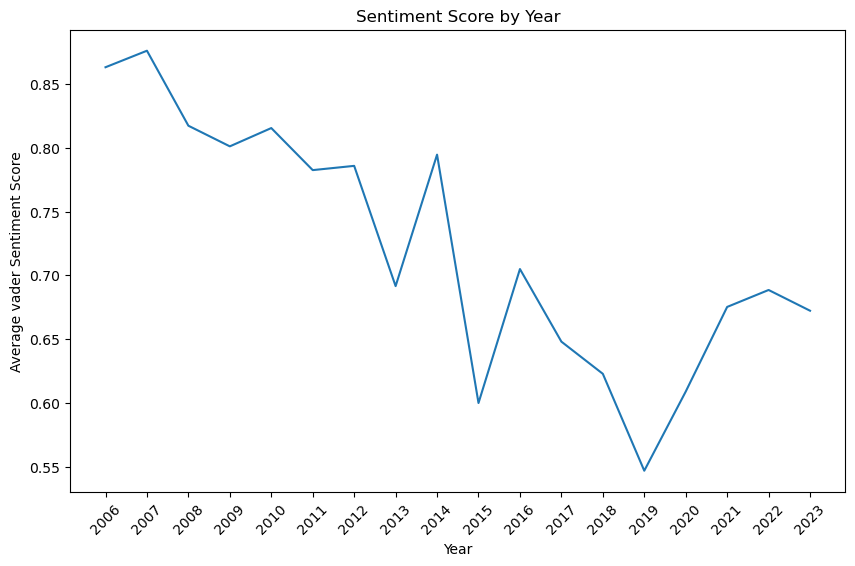

In [213]:
# using vaderSentiment at transcript level
analyzer = SentimentIntensityAnalyzer()


def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores["compound"]

df_sentiment['vsentiment'] = df_sentiment['clean_transcript'].apply(get_sentiment_score)
df_sentiment['year'] = pd.to_datetime(df_sentiment['published_timestamp']).dt.year.astype(int)
plt.figure(figsize=(10, 6))
df_sentiment.groupby('year')['vsentiment'].mean().plot(kind='line')
plt.title('Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average vader Sentiment Score')
plt.xticks(df_sentiment['year'].unique(), rotation=45)
plt.show()

In [214]:
#using vaderSentiment at word level

def get_word_polarity_scores(text):
    words = nltk.word_tokenize(text)
    word_polarity_scores = {}

    for word in words:
        score = analyzer.polarity_scores(word)["compound"]
        word_polarity_scores[word] = score
    return word_polarity_scores

df_sentiment["word_polarity_scores"] = df_sentiment["clean_transcript"].apply(get_word_polarity_scores)

def get_text_polarity_score(word_polarity_scores):
    scores = list(word_polarity_scores.values())
    if scores:
        average = sum(scores) / len(scores)
    else:
        average = 0
    return average

df_sentiment["text_polarity_score"] = df_sentiment["word_polarity_scores"].apply(get_text_polarity_score)

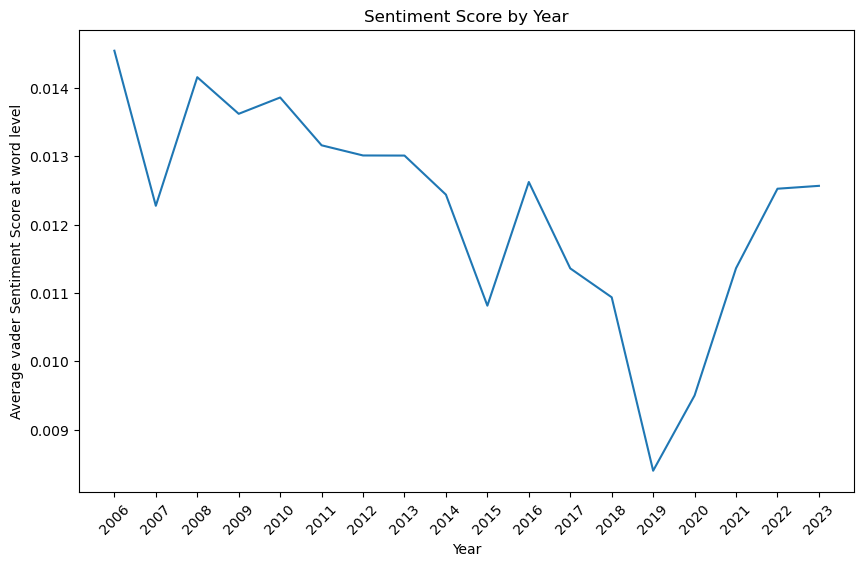

In [218]:
df_sentiment['year'] = pd.to_datetime(df_sentiment['published_timestamp']).dt.year.astype(int)
plt.figure(figsize=(10, 6))
df_sentiment.groupby('year')['text_polarity_score'].mean().plot(kind='line')
plt.title('Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average vader Sentiment Score at word level')
plt.xticks(df_sentiment['year'].unique(), rotation=45)
plt.show()

In [215]:
positive_threshold = 0.5
negative_threshold = -0.5

df_positive = df_sentiment[df_sentiment["word_polarity_scores"].apply(lambda x: any(score >= positive_threshold for score in 
                                                                                    x.values()))]
df_negative = df_sentiment[df_sentiment["word_polarity_scores"].apply(lambda x: any(score <= negative_threshold for score in 
                                                                                    x.values()))]

for i, row in df_positive.iterrows():
    text = row["clean_transcript"]
    word_polarity_scores = row["word_polarity_scores"]
    for word in text.split():
        if word in word_polarity_scores:
            if word_polarity_scores[word] >= positive_threshold:
                fdist_positive[word] += 1
positive_words = {word: freq for word, freq in fdist_positive.items() if freq > 10}



fdist_negative = FreqDist()
for i, row in df_negative.iterrows():
    text = row["clean_transcript"]
    word_polarity_scores = row["word_polarity_scores"]
    for word in text.split():
        if word in word_polarity_scores:
            if word_polarity_scores[word] <= negative_threshold:
                fdist_negative[word] += 1

negative_words = {word: freq for word, freq in fdist_negative.items() if freq > 10}

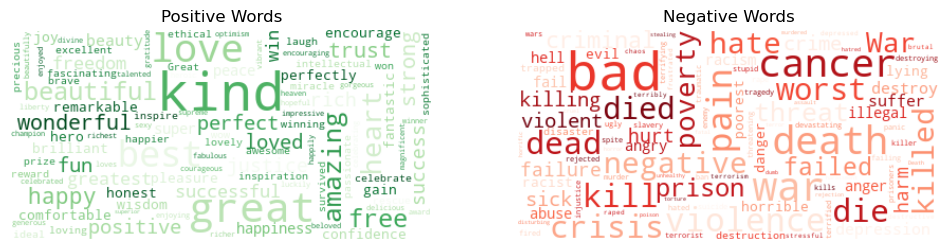

In [216]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
# Create a word cloud for the positive words
wc_positive = WordCloud(background_color="white", max_words=100, max_font_size=50, colormap=matplotlib.colormaps["Greens"])
wc_positive.generate_from_frequencies(positive_words)

# Create a word cloud for the negative words
wc_negative = WordCloud(background_color="white", max_words=100, max_font_size=50, colormap=matplotlib.colormaps["Reds"])
wc_negative.generate_from_frequencies(negative_words)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Words")
plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Words")
plt.show()

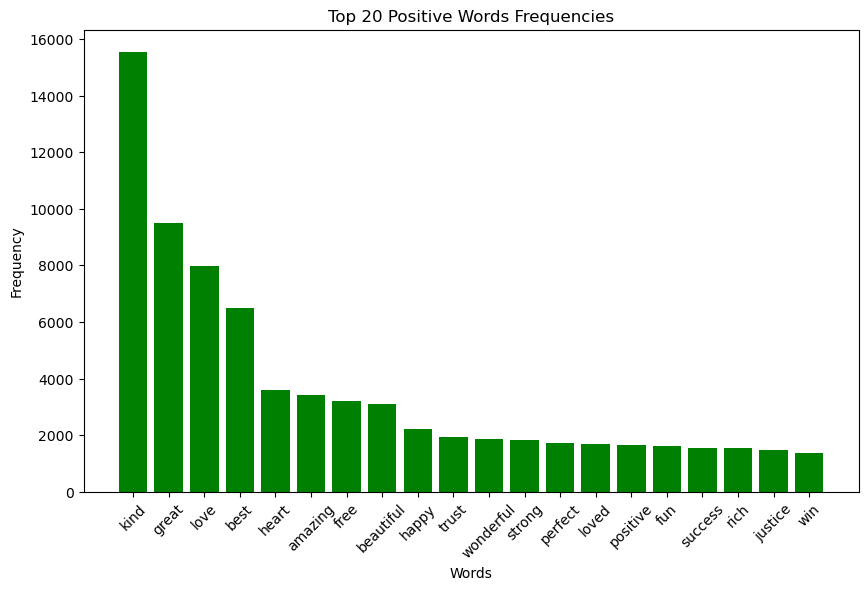

In [223]:
positive_words_series = pd.Series(positive_words)
positive_words_series = positive_words_series.sort_values(ascending=False)
top_20_positive_words = positive_words_series.head(20)

plt.figure(figsize=(10, 6))
plt.bar(top_20_positive_words.index, top_20_positive_words.values, color='green')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Positive Words Frequencies')
plt.xticks(top_20_positive_words.index, rotation=45)
plt.show()

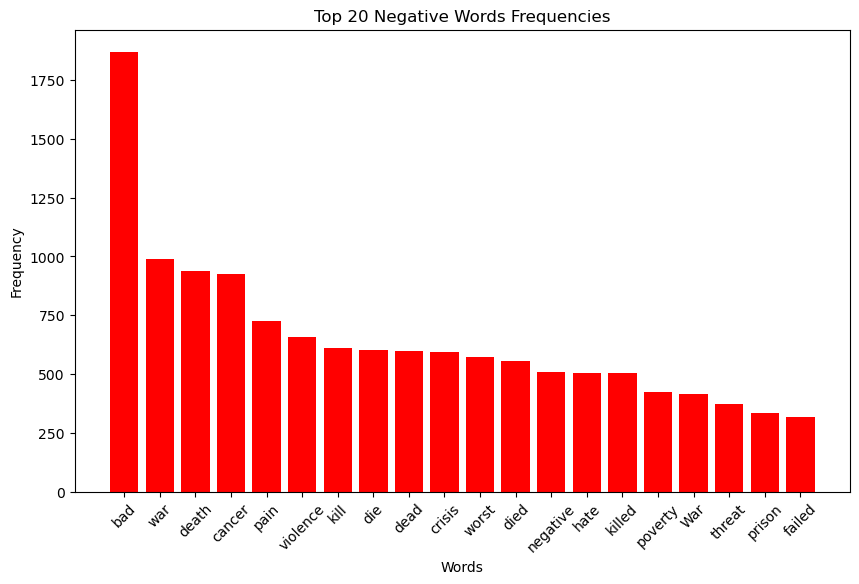

In [225]:
negative_words_series = pd.Series(negative_words)
negative_words_series = negative_words_series.sort_values(ascending=False)
top_20_negative_words = negative_words_series.head(20)

plt.figure(figsize=(10, 6))
plt.bar(top_20_negative_words.index, top_20_negative_words.values, color='red')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Negative Words Frequencies')
plt.xticks(top_20_negative_words.index, rotation=45)
plt.show()

## 3. Cosine similarity

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df['fully_cleaned']= df['transcript'].apply(clean_text)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['fully_cleaned'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(cosine_sim.shape)
print(cosine_sim[0])

(4959, 4959)
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
#plt.figure(figsize=(20,20))
#sns.heatmap(cosine_sim, annot=True, cmap='Blues')#, xticklabels=df['title'], yticklabels=df['title'], annot_kws={'size': 8})
#plt.title('Cosine Similarity Matrix for TED Talks', fontsize=16)
#plt.show()
k = 10 
ind = np.unravel_index (np.argsort (cs, axis=None)[-k:], cs.shape)
rows = np.array ([‘A’, ‘B’, ‘C’, ‘D’])[ind[0]] 
cols = np.array ([‘A’, ‘B’, ‘C’, ‘D’])[ind1]
cs_subset = cs[ind]

plt.figure () 
plt.imshow (cs_subset, cmap=‘hot’, interpolation=‘nearest’) 
plt.xticks (range (k), cols) plt.yticks (range (k), rows) 
plt.colorbar () plt.show ()

In [ ]:
sns.clustermap(cosine_sim, cmap='hot', annot=True, dendrogram_ratio=0.1) 
plt.show()

## 4. Jaccard similarity

In [11]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import jaccard_score

sentences = list(df['fully_cleaned'])
vectorizer = CountVectorizer(binary=True)

vectors = vectorizer.fit_transform(sentences)
vectors = vectors.toarray()

jaccard_sim = []

for i in range(len(vectors)): 
    for j in range(i+1, len(vectors)): 
        score = jaccard_score(vectors[i], vectors[j], average='micro') 
        jaccard_sim.append((score, i, j))

KeyboardInterrupt: 

In [ ]:
x = [i for score, i, j in jaccard_sim] 
y = [j for score, i, j in jaccard_sim] 
c = [score for score, i, j in jaccard_sim]


plt.scatter(x, y, c=c, cmap='Blues') 
plt.colorbar() 
plt.xlabel('Word set index') 
plt.ylabel('Word set index') plt.show()

In [ ]:
n = len(word_sets) # Number of word sets 
jaccard_matrix = np.zeros((n, n)) # Initialize an empty matrix 
for score, i, j in jaccard_sim: # Loop through the list of scores 
    jaccard_matrix[i, j] = score # Fill the matrix with the scores 
    jaccard_matrix[j, i] = score # The matrix is symmetric

jaccard_df = pd.DataFrame(jaccard_matrix, index=df.index, columns=df.index)

sns.heatmap(jaccard_df, annot=True, cmap=‘Blues’) 
plt.show()

import matplotlib.pyplot as plt

Extract the x and y coordinates and the Jaccard similarity scores from the list


## 5. Euclidean distance

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

vectorizer2 = CountVectorizer()

count_matrix = vectorizer2.fit_transform(df['fully_cleaned'])

euclidean_dist = euclidean_distances(count_matrix, count_matrix)

print(euclidean_dist.shape)
print(euclidean_dist[0])


(4959, 4959)
[ 0.         78.09609465 42.84857057 ... 31.04834939 30.69201851
 41.41255848]


In [86]:


df['clean_transcript'] = df['transcript'].apply(clean)

# Split the cleaned transcripts into words
doc_clean = [doc.split() for doc in df['clean_transcript']] 

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Running and Training LDA model on the document term matrix
lda = LdaModel
ldamodel = lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)


In [88]:


# Prepare the visualization
vis_data = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)
